<a href="https://colab.research.google.com/github/BeBop-7D0/SoftMax_regresisin/blob/main/4_1_4_3_Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import torch

from d2l import torch as d2l
import random
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# Загрузка из MNIST
class FashionMNIST(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor() ])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True
        )

        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True
        )

In [ ]:
data = FashionMNIST(resize=(32, 32))
print(f'num of train img: {len(data.train)}, num of val img: {len(data.val)}')

100%|██████████| 26421880/26421880 [00:01<00:00, 14205919.00it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 236956.58it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4313586.25it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19382654.39it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

num of train img: 60000, num of val img: 10000


In [ ]:
# Данные представляются в виде тензоров (c, h, w), where c is channel of color
data.train[0][0].shape

torch.Size([1, 32, 32])

In [ ]:
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
    labels =  ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(idx)] for idx in indices]

In [ ]:
data.text_labels([1, 2])

['trouser', 'pullover']

In [ ]:
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train=True):
    data = self.train if train else self.val
    return DataLoader(data, batch_size=self.batch_size, shuffle=train, num_workers=0)


In [ ]:
X, y = next(iter(data.get_dataloader(train=True)))
X.shape, y.shape, y.dtype

(torch.Size([64, 1, 32, 32]), torch.Size([64]), torch.int64)

In [ ]:
tic = time.time()
for X, y in data.get_dataloader():
    continue
f"{time.time()-tic} sec"

'11.022284746170044 sec'

In [ ]:
def show_images(imgs, num_rows, num_cols, title=None, scale=1.5):
    raise NotImplementedError


In [ ]:
@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


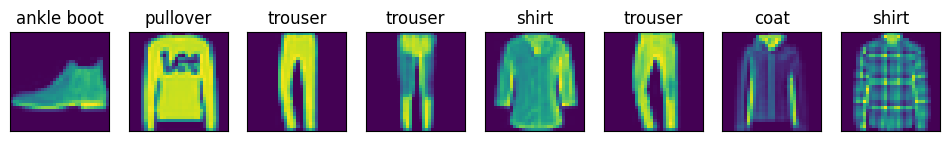

In [ ]:
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [ ]:
def text_labels(indices):
    labels =  ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(idx)] for idx in indices]

In [ ]:
# Модель классификатора
class Classifier(d2l.Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)


In [ ]:
@d2l.add_to_class(d2l.Module)
def configure_optimizer(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)


In [ ]:
@d2l.add_to_class(Classifier)
def accuracy(self, Y_hat, Y, average=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if average else compare

In [ ]:
def softmax(X):
    norm = torch.exp(X).sum(dim=1, keepdim=True)
    result = X.exp() / norm
    return result


In [ ]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
    def parameters(self):
        return [self.W, self.b]

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [ ]:
y = torch.tensor([0, 1])
y_hat = torch.tensor([[1, 0, 0], [0, 0.2, 0.999]])
answer = y_hat[[0, 1], y]
print(answer)

tensor([1.0000, 0.2000])


In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

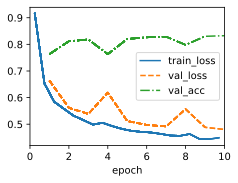

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=28*28, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)